# Introduction to PyCBC Inference 3: Results files and plotting
### Collin Capano

In this tutorial, we take a closer look at the output files, including how to load samples from them. We then illustrate more advanced options in `pycbc_inference_plot_posterior`, and show how to create a posterior file. We will use an already complete results file.

### Prerequisites

In [1]:
import sys
!{sys.executable} -m pip install pycbc lalsuite ligo-common --no-cache-dir

# This is needed to access the executables on sciserver. On a personal machine this should be ignore.
path = %env PATH
%env PATH=$path:/home/idies/miniconda3/envs/py27/bin 

env: PATH=/home/idies/miniconda3/bin:/home/idies/miniconda3/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/home/idies/miniconda3/envs/py27/bin


In [2]:
from __future__ import print_function
import os
import matplotlib
%matplotlib notebook
from matplotlib import pyplot

from IPython.display import Image

## Get the file

We will download a result file from a fully completed analysis, from [here](https://www.atlas.aei.uni-hannover.de/~cdcapano/projects/pycbc_inference/workshop-may2019/bbh_injection). In this analysis, we injected a binary black hole simulation into LIGO data (20 seconds after GW150914). The injection parameters are:
```
tc = 1126259482.420
mass1 = 37
mass2 = 32
ra = 2.2
dec = -1.25
inclincation = 2.5
coa_phase = 1.5
polarization = 1.75
distance = 100
f_ref = 20
f_lower = 18
approximant = IMRPhenomPv2
taper = start
```
These are similar to GW150914, although it is about a factor of 5 closer in distance. You can see the config file used and the run script in the [linked directory](https://www.atlas.aei.uni-hannover.de/~cdcapano/projects/pycbc_inference/workshop-may2019/bbh_injection).

In [3]:
if not os.path.exists('bbh_results.hdf'):
    !wget https://www.atlas.aei.uni-hannover.de/~cdcapano/projects/pycbc_inference/bbh_injection/bbh_results.hdf

--2019-05-14 01:26:55--  https://www.atlas.aei.uni-hannover.de/~cdcapano/projects/pycbc_inference/bbh_injection/bbh_results.hdf
Resolving www.atlas.aei.uni-hannover.de (www.atlas.aei.uni-hannover.de)... 130.75.116.230
Connecting to www.atlas.aei.uni-hannover.de (www.atlas.aei.uni-hannover.de)|130.75.116.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 554655500 (529M) [application/x-hdf]
Saving to: 'bbh_results.hdf'

100%[======================================>] 554,655,500 24.8MB/s   in 21s    

2019-05-14 01:27:18 (24.7 MB/s) - 'bbh_results.hdf' saved [554655500/554655500]



## The results file

The results file `bbh_results.hdf` is an HDF file. We could use the standard python module for reading HDF files [h5py](http://docs.h5py.org/en/stable/) to examine it. However, there are classes in [pycbc.inference.io](http://pycbc.org/pycbc/latest/html/pycbc.inference.io.html) that inherit from [h5py.File](http://docs.h5py.org/en/stable/high/file.html#file-objects) and add several convenience functions that make it easier to read samples from the file. There is one class for each type of sampler. So to load the file, we will use [pycbc.inference.io.loadfile](http://pycbc.org/pycbc/latest/html/pycbc.inference.io.html#pycbc.inference.io.loadfile). This function automatically determines which class to use to read the file, based on what is in the file.

In [4]:
from pycbc.inference.io import loadfile

In [5]:
fp = loadfile('bbh_results.hdf', 'r')

The top-level groups in the HDF file:

In [6]:
fp.keys()

[u'data', u'injections', u'sampler_info', u'samples']

HDF files also have `attrs`. These are basically dictionaries that can be used to store metadata. Let's look at what metadata `pycbc_inference` stored in the file:

In [7]:
fp.attrs.items()

[(u'filetype', 'emcee_pt_file'),
 (u'L1_likelihood_low_freq', 20.0),
 (u'sampler', 'emcee_pt'),
 (u'cmd',
  array(['/work/cdcapano/virtualenv/pycbc-1.13.7/bin/pycbc_inference --verbose --seed 29111 --instruments H1 L1 --gps-start-time 1126259472 --gps-end-time 1126259488 --frame-files H1:H-H1_GWOSC_4KHZ_R1-1126257415-4096.gwf L1:L-L1_GWOSC_4KHZ_R1-1126257415-4096.gwf --channel-name H1:GWOSC-4KHZ_R1_STRAIN L1:GWOSC-4KHZ_R1_STRAIN --strain-high-pass 15 --pad-data 8 --psd-estimation H1:median L1:median --psd-start-time 1126258970 --psd-end-time 1126259994 --psd-segment-length 16 --psd-segment-stride 8 --psd-inverse-length 4 --sample-rate 2048 --data-conditioning-low-freq 20 --config-file bbh_example.ini --output-file bbh_results.hdf --nprocesses 28 --injection-file injection.hdf --force'],
        dtype='|S678')),
 (u'resume_points', array([0])),
 (u'model', 'marginalized_phase'),
 (u'thinned_by', 8),
 (u'variable_params',
  array(['tc', 'mass1', 'mass2', 'spin1_a', 'spin1_azimuthal',
   

### Sampler info
The `sampler_info` group contains information about the sampler. The data that's stored in this group is sampler-specific. This is what was stored for this run, which used `emcee_pt`:

In [8]:
fp['sampler_info'].keys()

[u'acceptance_fraction', u'acls', u'burn_in_tests', u'random_state']

Every group can have their own `.attrs`; let's look at the `sampler_info` group's `attrs`:

In [9]:
fp['sampler_info'].attrs.items()

[(u'nwalkers', 1000),
 (u'ntemps', 4),
 (u'niterations', 6000),
 (u'betas', array([1.        , 0.53206772, 0.28309606, 0.15062628])),
 (u'acl', 9.0),
 (u'burn_in_test', 'nacl & max_posterior'),
 (u'is_burned_in', True),
 (u'burn_in_iteration', 5544)]

### Injection data
If we are analyzing an injection, as in this case, an `injections` group is added to the file. This group contains all the information about the injection(s) that was (were) performed. Let's take a look:

In [10]:
fp['injections'].keys()

[]

In [11]:
fp['injections'].attrs.items()

[(u'static_args',
  array(['distance', 'f_lower', 'mass1', 'mass2', 'taper', 'f_ref',
         'approximant', 'polarization', 'ra', 'coa_phase', 'dec', 'tc',
         'inclincation'], dtype='|S12')),
 (u'injtype', 'cbc'),
 (u'cmd',
  '/work/cdcapano/virtualenv/pycbc-1.13.7/bin/pycbc_create_injections --verbose --config-files injection.ini --ninjections 1 --seed 10 --output-file injection.hdf --variable-params-section variable_params --static-params-section static_params --dist-section prior'),
 (u'distance', 100.0),
 (u'f_lower', 18.0),
 (u'mass1', 37.0),
 (u'mass2', 32.0),
 (u'taper', 'start'),
 (u'f_ref', 20.0),
 (u'approximant', 'IMRPhenomPv2'),
 (u'polarization', 1.75),
 (u'ra', 2.2),
 (u'coa_phase', 1.5),
 (u'dec', -1.25),
 (u'tc', 1126259482.42),
 (u'inclincation', 2.5)]

Note that there was no data sets stored in the `injections` group (`.keys()` returned an empty list). All of the injection info was in the `.attrs`. This was because a single injection was performed. If multiple injections had been done, the parameters that were varied would be stored as datasets.

### Samples

The samples that the sampler produced are stored in the `samples` group. There is one data set for each variable parameter.

In [12]:
print(fp['samples'].keys())

[u'dec', u'distance', u'inclination', u'logjacobian', u'loglikelihood', u'logprior', u'mass1', u'mass2', u'polarization', u'ra', u'spin1_a', u'spin1_azimuthal', u'spin1_polar', u'spin2_a', u'spin2_azimuthal', u'spin2_polar', u'tc']


Additional data may be stored in the `samples` group `attrs`. In this case, because we used the `marinalized_phase` model, the log likelihood of the noise $\log p(d|n) = -\left<d,\,d\right>/2$ is stored.

In [13]:
fp['samples'].attrs.items()

[(u'lognl', -826947.5569803874),
 (u'H1_lognl', -78440.25940197767),
 (u'L1_lognl', -748507.2975784098)]

Lets look at the shape of the datasets in the samples group. They all have the same shape, so we can just look at one of the parameters.

In [14]:
print(fp['samples/mass1'].shape)

(4, 1000, 750)


The shape of the dataset is `ntemps x nwalkers x n thinned iteration`. This run used 4 temperatures and 1000 walkers. Due to `max-samples-per-chain` being set to 1000, the data set has been thinned to include 750 samples from each walker and temperature.

If this had been an `emcee` run (which uses no temperatures), the samples datasets would have been two dimensional: `nwalkers x niterations`. If it had been a nested sampling run (with either CPNest or Multinest), the datasets would have been 1 dimensional. **The format of the samples data is sampler dependent.** This is why we have separate classes to read the results file.

## Load samples

Now lets load the samples. We can use the `read_samples` function to do this. This takes as a the first argument a list of parameters to load. Here, we'll load all of the parameters. It also takes additional keyword arguments. These arguments are sampler-specific. For `emcee_pt` if we provide no additional keyword arguments, we'll get all temperatures. We just want the coldest temperature `temp=0`, as that is the posterior.

If we provide no other arguments, `read_samples` will load all of the independent samples post burn-in. That is, it will get samples from all walkers, starting from the burn in iteration, and thinned by the ACL (it gets this information from the file's `.attrs`; specifically, the `thin_start` and `thin_interval` attributes). The samples are flattened into a 1D array.

In [15]:
samples = fp.read_samples(fp['samples'].keys(), temps=0)

In [16]:
print(samples.shape)

(7000,)


So, we have 7000 independent samples. What sort of object is `samples`?

In [17]:
type(samples)

pycbc.io.record.FieldArray

The samples have been returned as a [FieldArray](http://pycbc.org/pycbc/latest/html/pycbc.io.html#pycbc.io.record.FieldArray). A `FieldArray` is a wrapper around [`numpy` structured arrays](https://docs.scipy.org/doc/numpy/user/basics.rec.html) (actually, it inherits from `numpy`'s [record array](https://docs.scipy.org/doc/numpy/user/basics.rec.html#record-arrays), which in turn inherits from structured arrays). Structured arrays allow multiple parameters to be stored in a single array. `FieldArray` adds several convenience features, which we will look at in a bit. Since they inherit from structured arrays, a `FieldArray` can be indexed by parameter name:

In [18]:
samples['mass1']

array([33.20120134, 33.11321062, 34.46360154, ..., 37.27286608,
       37.05199586, 33.69348728])

When you do, you get back a normal numpy array of the values stored for that parameter. We can see the full list of parameters that are stored using `.fieldnames` (This is an attribute added by `FieldArray`; it does not work for general structured arrays.)

In [19]:
print(samples.fieldnames)

('distance', 'mass1', 'mass2', 'spin2_polar', 'logprior', 'spin1_polar', 'tc', 'spin2_azimuthal', 'polarization', 'spin2_a', 'spin1_azimuthal', 'ra', 'spin1_a', 'dec', 'loglikelihood', 'logjacobian', 'inclination')


## Plot `mass1` and `mass2`

Let's make a scatter plot of the two mass parameters.

In [20]:
mass1 = samples['mass1']
mass2 = samples['mass2']

<IPython.core.display.Javascript object>


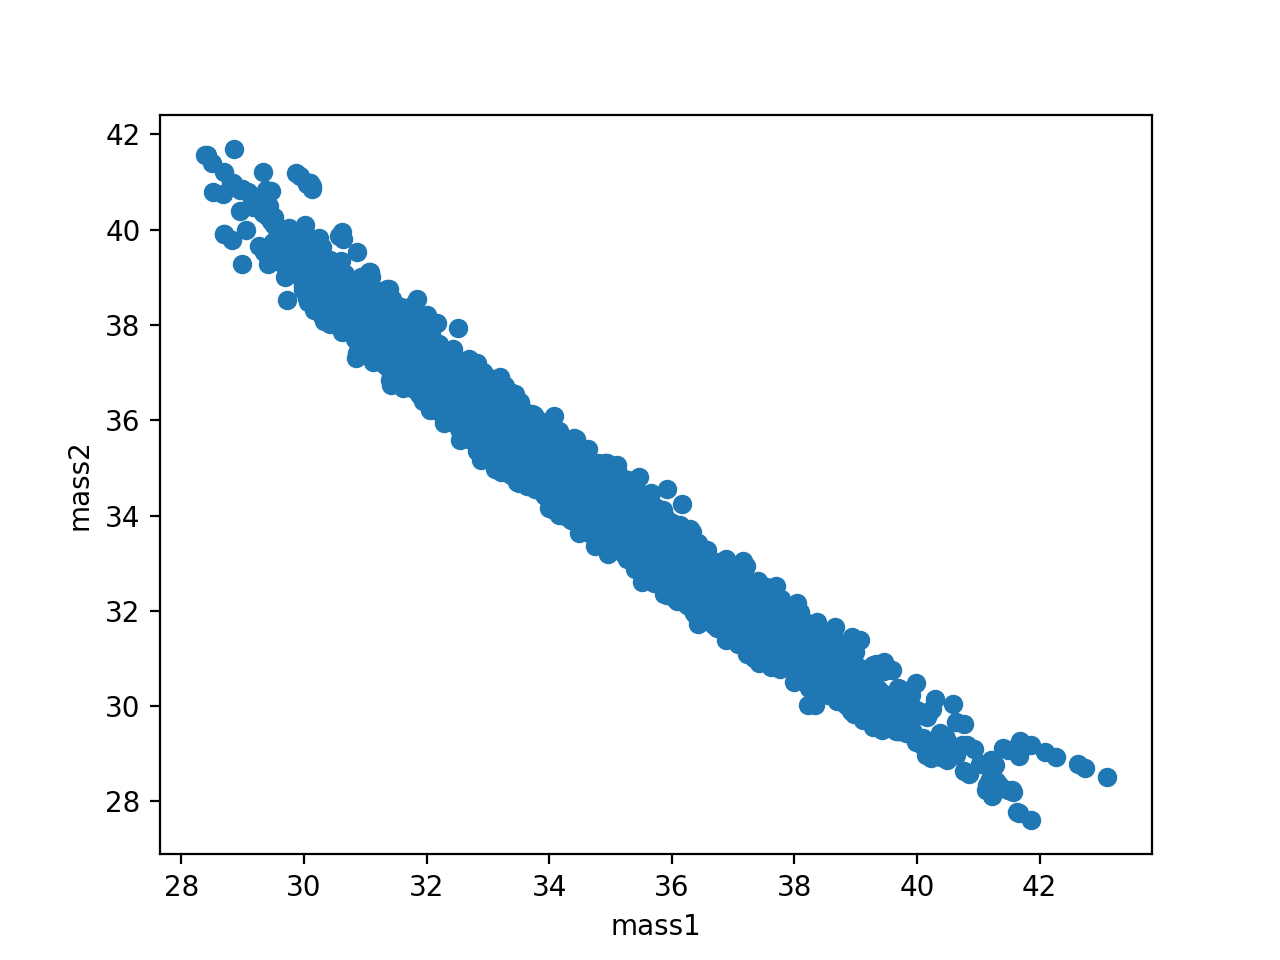

In [21]:
fig, ax = pyplot.subplots()
ax.scatter(mass1, mass2)
ax.set_xlabel('mass1')
ax.set_ylabel('mass2')
fig.show()

It looks like it converged, but something is odd here... we normally define `mass1 >= mass2`. But it looks like in our posterior samples, some points have `mass2 > mass1`. Lets confirm:

In [22]:
(mass1 >= mass2).all()

False

**The masses in the output file do not respect the convention that `mass1 >= mass2`.** This is expected: our prior (which was uniform for both masses in range $[10, 80)\,\mathrm{M}_\odot$) was symmetric between the masses.

But for plotting purposes, we want `mass1 >= mass2`. To do that, we can take advantage of one `FieldArray`'s key features.

The [pycbc.conversions](http://pycbc.org/pycbc/latest/html/pycbc.html#module-pycbc.conversions) provides a number of useful functions for converting parameters.

In [23]:
from pycbc import conversions

Included in the conversions module, the [primary_mass](http://pycbc.org/pycbc/latest/html/pycbc.html#pycbc.conversions.primary_mass) function pulls out the larger of the two masses in array of masses. Likewise, the [secondary_mass](http://pycbc.org/pycbc/latest/html/pycbc.html#pycbc.conversions.secondary_mass) function pulls out the smaller of the two. This can do what we want:

In [24]:
mass1 = conversions.primary_mass(samples['mass1'], samples['mass2'])
mass2 = conversions.secondary_mass(samples['mass1'], samples['mass2'])

In [25]:
(mass1 >= mass2).all()

True

<IPython.core.display.Javascript object>


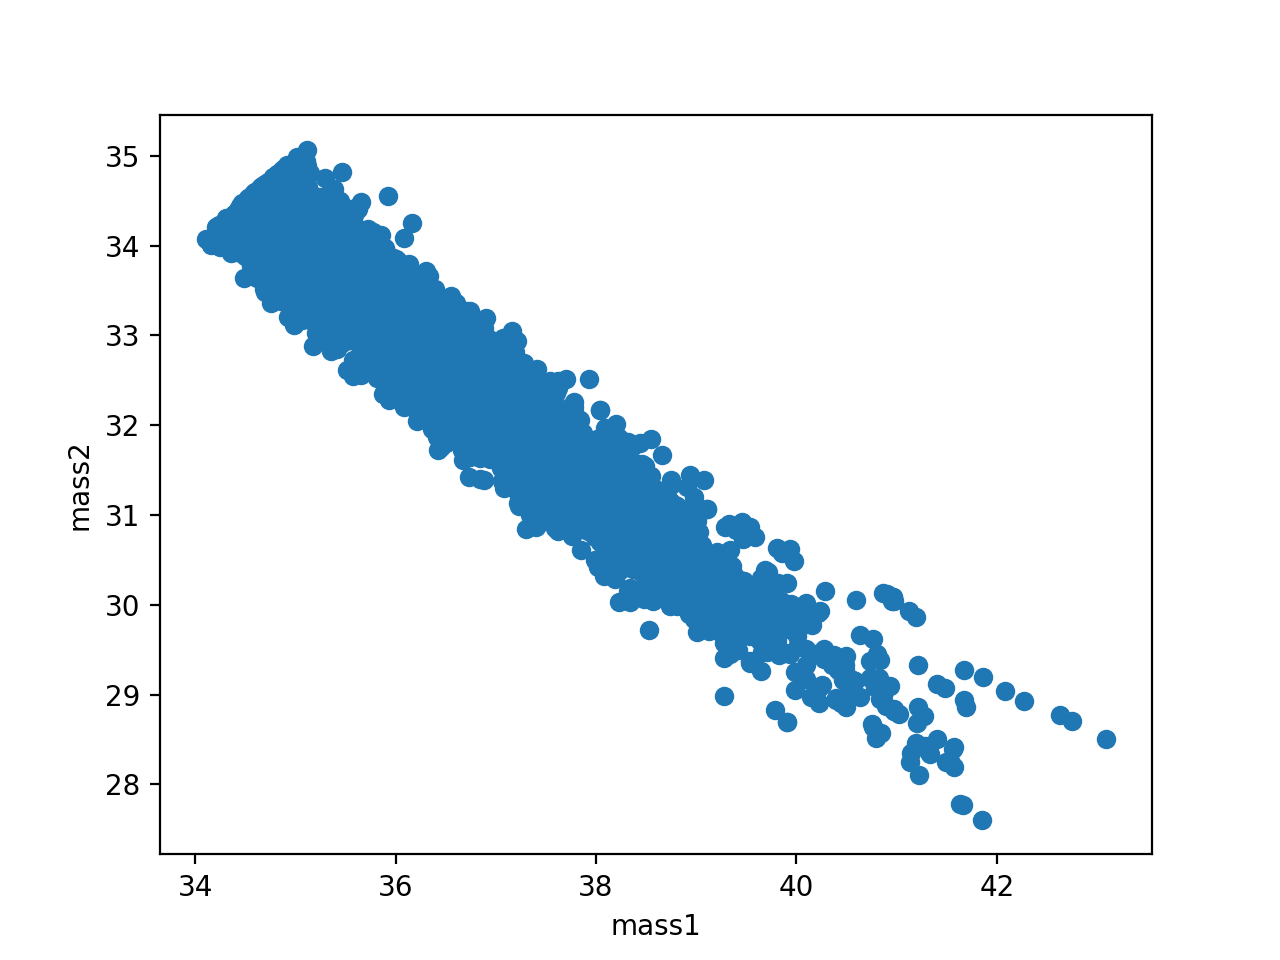

In [26]:
fig, ax = pyplot.subplots()
ax.scatter(mass1, mass2)
ax.set_xlabel('mass1')
ax.set_ylabel('mass2')
fig.show()

## Using functions with Field Arrays

We did not need to import and call the `primary_mass` and `secondary_mass` functions to apply them to the samples. Alternatively, we could of just passed these functions to the `samples` `FieldArray` as if they were parameters:

In [27]:
mass1 = samples['primary_mass(mass1, mass2)']
mass2 = samples['secondary_mass(mass1, mass2)']
(mass1 >= mass2).all()

True

This highlights the main purpose of `FieldArray`:

 * **`FieldArrays` can be passed functions of their parameters as strings.**

The available functions are any function in the [pycbc.conversions](http://pycbc.org/pycbc/latest/html/pycbc.html#module-pycbc.conversions), [pycbc.coordinates](http://pycbc.org/pycbc/latest/html/pycbc.html#module-pycbc.coordinates), or [pycbc.cosmology](http://pycbc.org/pycbc/latest/html/pycbc.html#module-pycbc.cosmology) modules. In addition, numpy math functions are available for use. The syntax is standard python.

For example, if we wanted `spin1z`:

In [28]:
samples['spin1_a * cos(spin1_polar)']

array([ 0.13687091,  0.12169151,  0.07400957, ...,  0.12116846,
        0.0248786 , -0.03085699])

Or redshift:

In [29]:
samples['redshift(distance)']

array([0.02260227, 0.02254325, 0.0221269 , ..., 0.0225306 , 0.02221046,
       0.02254982])

## The `--parameters` option

The main advantage of `FieldArrays` is that it means functions of parameters can be passed on the command line to plotting programs using the `--parameters` option. For example:

In [30]:
!pycbc_inference_plot_posterior \
    --input-file bbh_results.hdf \
    --output-file mass1_mass2.png \
    --parameters 'primary_mass(mass1, mass2):mass1' 'secondary_mass(mass1, mass2):mass2' \
    --plot-scatter \
    --plot-contours \
    --plot-marginal \
    --z-arg snr

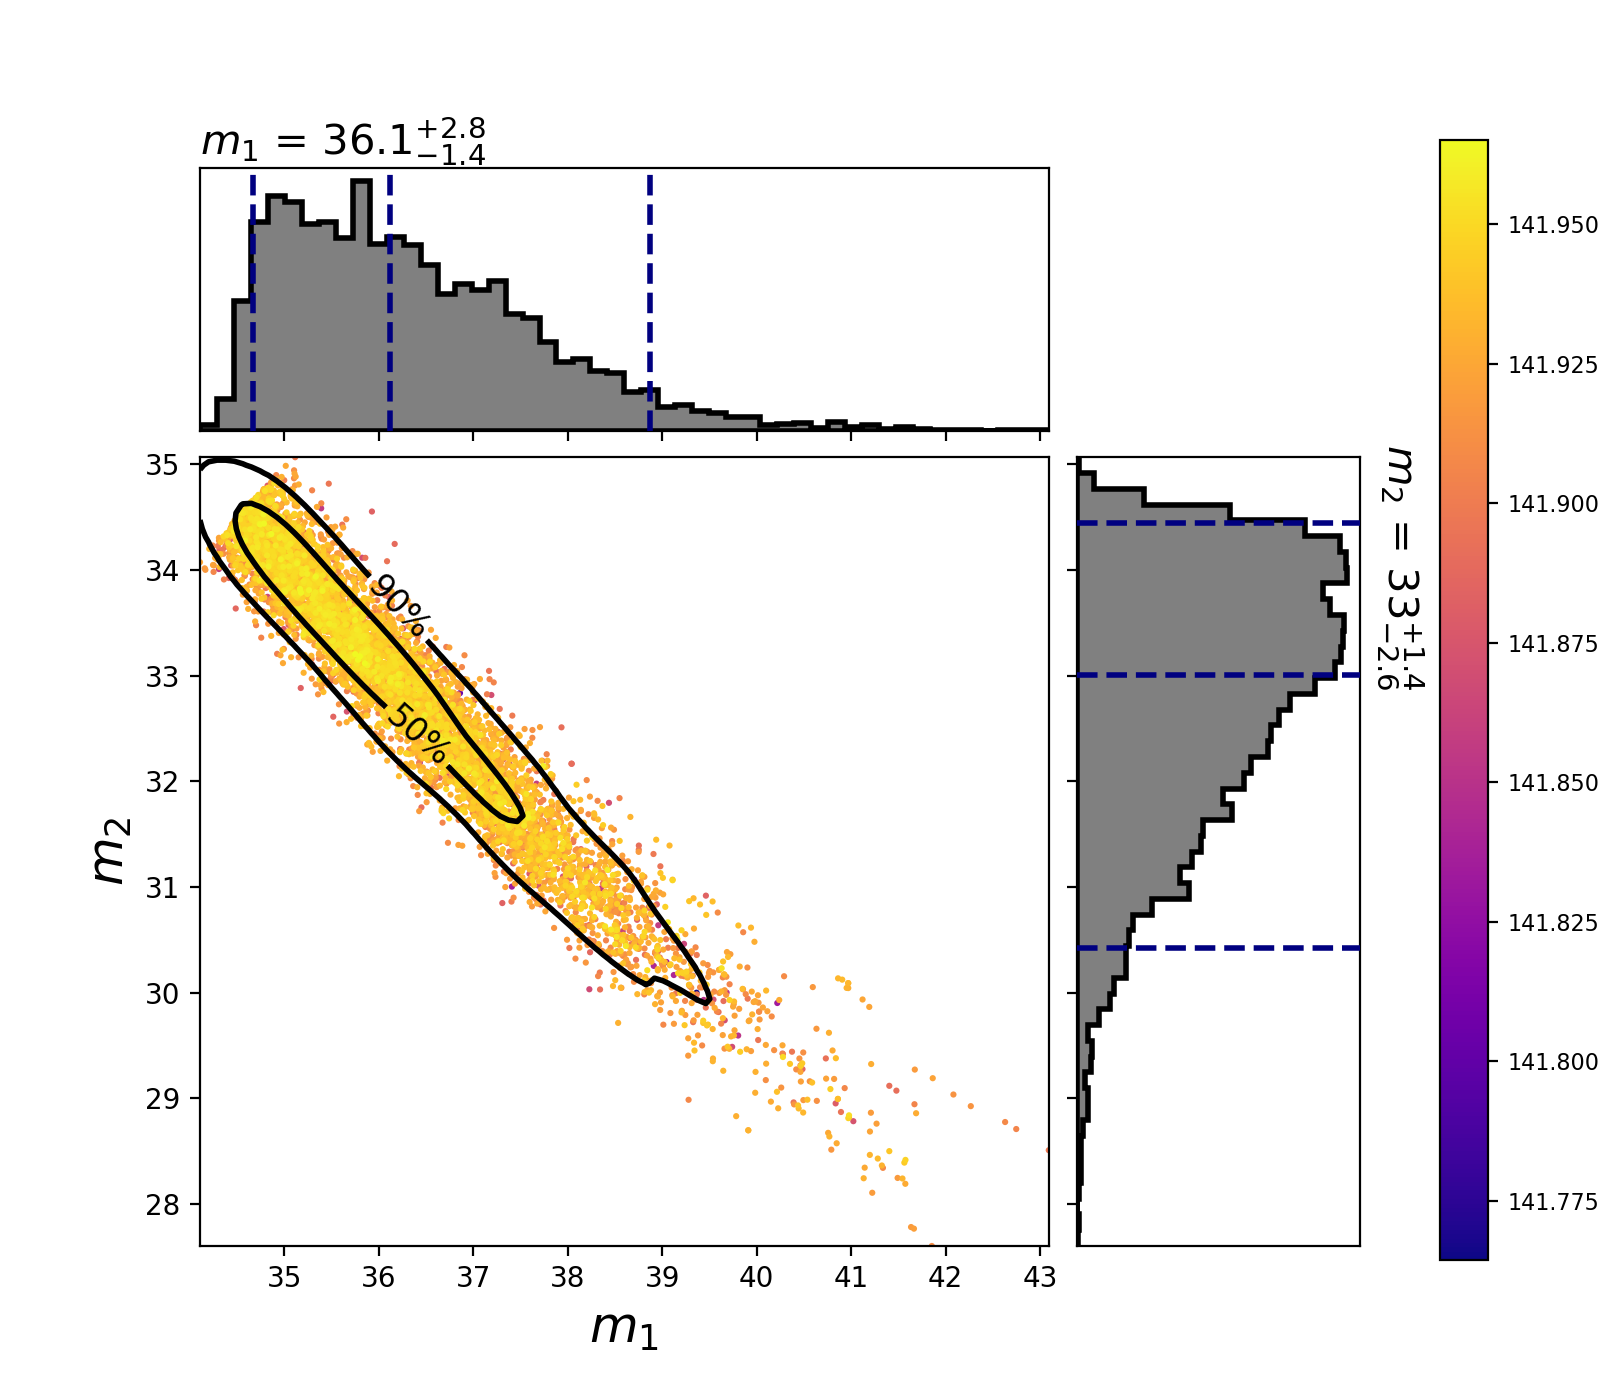

In [31]:
Image(filename='mass1_mass2.png', width=640, height=480)

Basically, any program with a `--parameters` option can take functions of parameters. Note that this option also allows you to pass a label for the parameters. The syntax for this is `--parameters parameter_to_plot:label`. If a label is provided that is recognized parameter in the [pycbc.waveform.waveform.parameters](https://github.com/gwastro/pycbc/blob/master/pycbc/waveform/parameters.py) module, the predefined label will be used for that parameter in the plot. This is why when we passed `mass1` and `mass2` as the labels, we got $m_1$ $m_2$ in the plot.

### File help
Like all executables in `pycbc`, `pycbc_inference_plot_posterior` has a help message for its available options. The help can be seen by running the program with `--help` (or `-h`):

In [32]:
!pycbc_inference_plot_posterior --help

usage: pycbc_inference_plot_posterior [-h] [--input-file FILE[:LABEL]
                                      [FILE[:LABEL] ...]] [-H]
                                      [--parameters PARAM[:LABEL]
                                      [PARAM[:LABEL] ...]] [--version]
                                      [--output-file OUTPUT_FILE] [--verbose]
                                      [--plot-prior PLOT_PRIOR [PLOT_PRIOR ...]]
                                      [--prior-nsamples PRIOR_NSAMPLES]
                                      [--plot-marginal]
                                      [--marginal-percentiles MARGINAL_PERCENTILES [MARGINAL_PERCENTILES ...]]
                                      [--plot-scatter] [--plot-density]
                                      [--plot-contours]
                                      [--contour-percentiles CONTOUR_PERCENTILES [CONTOUR_PERCENTILES ...]]
                                      [--mins PARAM:VAL [PARAM:VAL ...]]
                       

It can be difficult to remember all of the functions and parameters that you have available to you. For this reason, if you give the option `--file-help` (or `-H`), along with an input file, you will get a file-specific help message that tells you what parameters are available for plotting in the file, along with all of the functions you can use:

In [33]:
!pycbc_inference_plot_posterior --input-file bbh_results.hdf --file-help


Parameters available with this (these) input file(s):

dec distance inclination logjacobian loglikelihood logprior mass1
mass2 polarization ra spin1_a spin1_azimuthal spin1_polar spin2_a
spin2_azimuthal spin2_polar tc

Available pycbc functions (see http://pycbc.org/pycbc/latest/html for
more details):

cartesian_to_spherical, cartesian_to_spherical_azimuthal,
cartesian_to_spherical_polar, cartesian_to_spherical_rho, chi_a,
chi_eff, chi_eff_from_spherical, chi_p, chi_p_from_spherical,
chi_p_from_xi1_xi2, chi_perp_from_mass1_mass2_xi2,
chi_perp_from_spinx_spiny, chirp_distance,
cosmological_quantity_from_redshift, det_tc,
distance_from_comoving_volume, dquadmon_from_lambda,
eta_from_mass1_mass2, eta_from_q, eta_from_tau0_tau3,
final_mass_from_f0_tau, final_mass_from_initial,
final_spin_from_f0_tau, final_spin_from_initial,
freq_from_final_mass_spin, invq_from_mass1_mass2,
lambda_from_mass_tov_file, lambda_tilde, mass1_from_mass2_eta,
mass1_from_mchirp_eta, mass1_from_mchirp_q, mass1_fr

Note that this also reveals additional options that you can provide to the program. These options are sampler-specific (and thus file-specific), which is why they do not appear in the general help message. For example, passing a `--temps` option works for a file that was created by `emcee_pt`, but not for a file that was created by `emcee`. If you're ever unsure what is available, just run the `-H` option with your input file.

### Challenge:
Make a posterior plot of chirp mass ("mchirp") vs eta.

## Creating posterior files with `extract_samples`

It can get very tedious typing long functions on the command line every time you want to create a plot. Also, you may want to release your posterior samples along with a paper. Having different file formats depending on the sampler would make such a release confusing. Plus, the full samples file contains much more information than is necessary if you just want the posterior samples.

The program `pycbc_inference_extract_samples` can convert a samples file into a *posterior file*. Regardless of the sampler that was used:

 * **Posterior files all have a "samples" group that contains 1D datasets of the posterior samples.**
 
In process of creating the file, `pycbc_inference_extract_samples` can also be used to write out functions of the parameters as new datasets. This is because it also takes a `--parameters` option, except that here the labels part gives the name of the parameter in the new file. Nuisance parameters can be excluded, along with the other groups, such as `sampler_info`.

For example, in the following, we create a posterior file containing the component masses (which we sort such that `mass1` $\geq$ `mass2`) and the log likelihood. We also add the chirp mass and symmetric mass ratio `eta`.

In [34]:
!pycbc_inference_extract_samples --verbose \
    --input-file bbh_results.hdf \
    --output-file mass_posterior.hdf \
    --parameters \
        'primary_mass(mass1, mass2):mass1' \
        'secondary_mass(mass1, mass2):mass2' \
        'mchirp_from_mass1_mass2(mass1, mass2):mchirp' \
        'eta_from_mass1_mass2(mass1, mass2):eta' \
        loglikelihood \
    --skip-groups data sampler_info

2019-05-14 01:28:05,336 Reading input file bbh_results.hdf
2019-05-14 01:28:05,339 Loading samples
2019-05-14 01:28:05,368 Using 7000 samples
2019-05-14 01:28:05,403 Copying info


Let's load the posterior file and examine it.

In [35]:
fp = loadfile('mass_posterior.hdf', 'r')

In [36]:
fp.keys()

[u'injections', u'samples']

In [37]:
fp['samples'].keys()

[u'eta', u'loglikelihood', u'mass1', u'mass2', u'mchirp']

In [38]:
fp['samples']['mchirp'].shape

(7000,)

In [39]:
fp.attrs.items()

[(u'filetype', 'posterior_file'),
 (u'L1_likelihood_low_freq', 20.0),
 (u'sampler', 'emcee_pt'),
 (u'cmd',
  array(['/work/cdcapano/virtualenv/pycbc-1.13.7/bin/pycbc_inference --verbose --seed 29111 --instruments H1 L1 --gps-start-time 1126259472 --gps-end-time 1126259488 --frame-files H1:H-H1_GWOSC_4KHZ_R1-1126257415-4096.gwf L1:L-L1_GWOSC_4KHZ_R1-1126257415-4096.gwf --channel-name H1:GWOSC-4KHZ_R1_STRAIN L1:GWOSC-4KHZ_R1_STRAIN --strain-high-pass 15 --pad-data 8 --psd-estimation H1:median L1:median --psd-start-time 1126258970 --psd-end-time 1126259994 --psd-segment-length 16 --psd-segment-stride 8 --psd-inverse-length 4 --sample-rate 2048 --data-conditioning-low-freq 20 --config-file bbh_example.ini --output-file bbh_results.hdf --nprocesses 28 --injection-file injection.hdf --force'],
        dtype='|S678')),
 (u'resume_points', array([0])),
 (u'model', 'marginalized_phase'),
 (u'variable_params',
  array(['tc', 'mass1', 'mass2', 'spin1_a', 'spin1_azimuthal',
         'spin1_polar',

In [40]:
posterior_samples = fp.read_samples(['mass1', 'mass2'])
mass1 = posterior_samples['mass1']
mass2 = posterior_samples['mass2']

In [41]:
(mass1 >= mass2).all()

True

Note that the posterior file is much smaller than the full samples file:

In [42]:
!ls -lh bbh_results.hdf mass_posterior.hdf

-rw-r--r--. 1 idies idies 529M May 13 20:47 bbh_results.hdf
-rw-r--r--. 1 idies idies 297K May 14 01:28 mass_posterior.hdf


Now lets create a posterior plot of all of the mass parameters using the posterior file. We no longer need to pass the functions on the command line:

In [43]:
!pycbc_inference_plot_posterior \
    --input-file mass_posterior.hdf \
    --output-file posterior_mass1_mass2.png \
    --parameters mass1 mass2 mchirp eta \
    --plot-scatter \
    --plot-contours \
    --plot-marginal \
    --z-arg snr

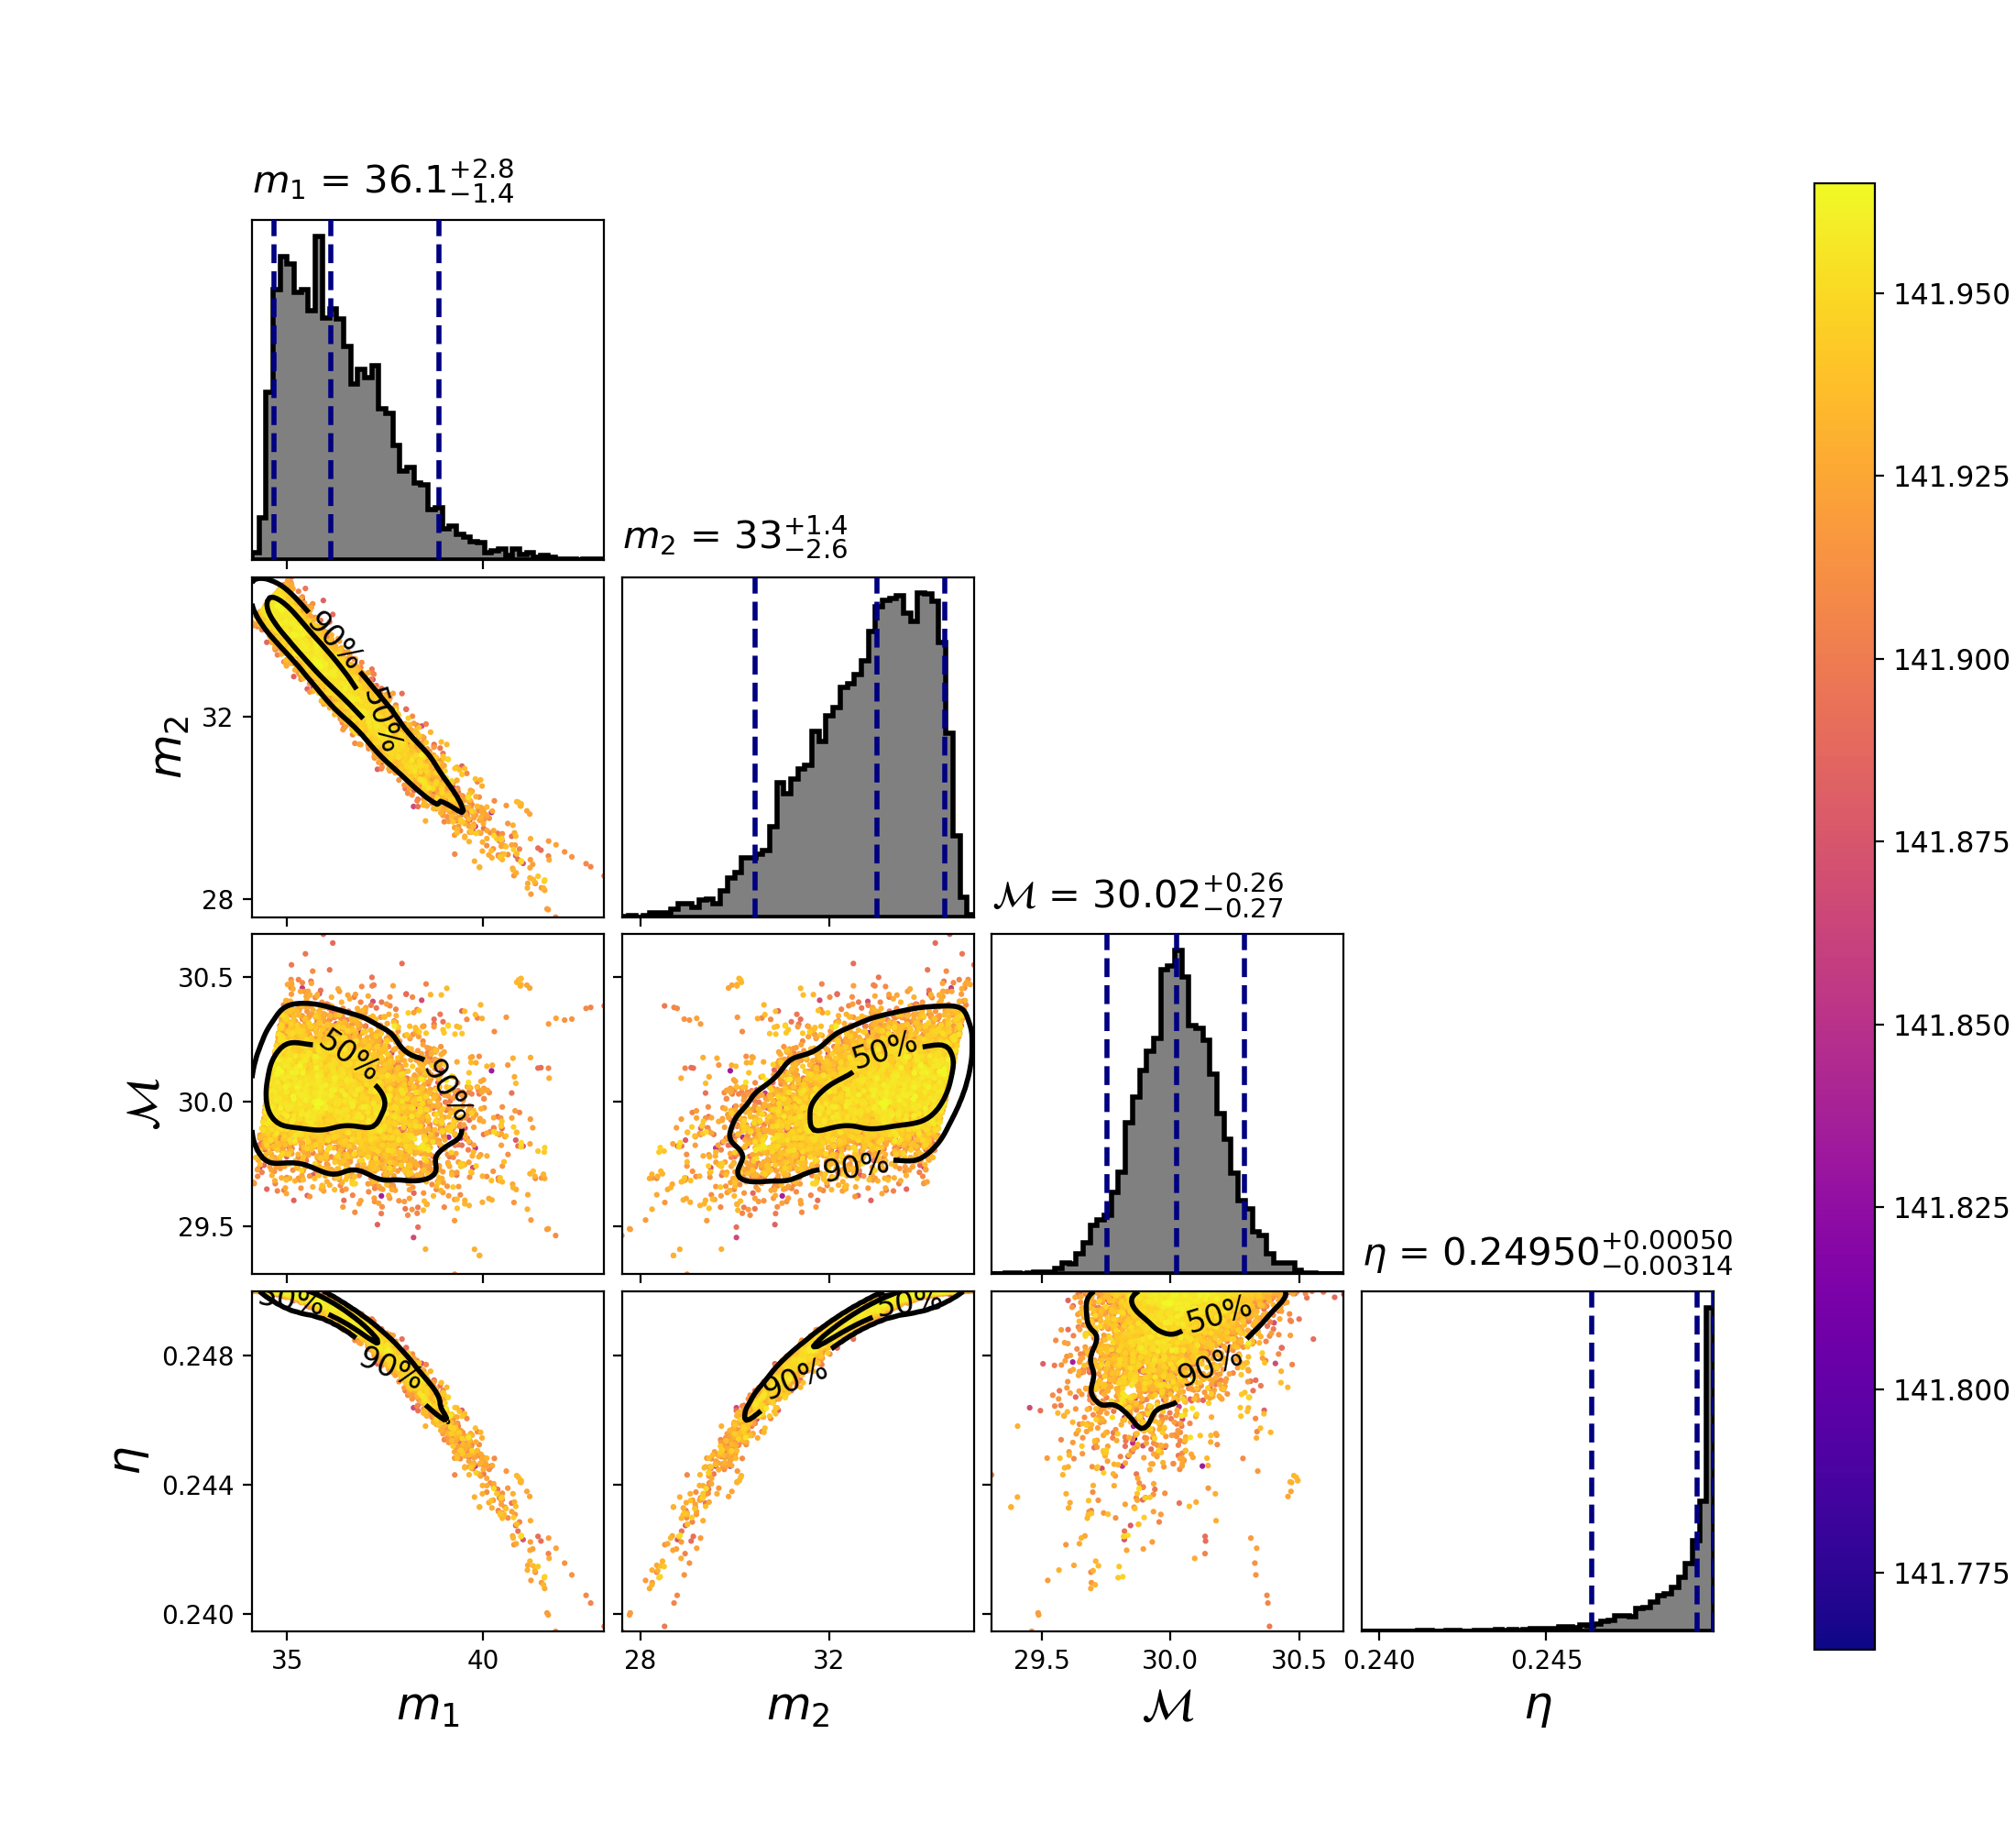

In [44]:
Image(filename='posterior_mass1_mass2.png', width=640, height=480)

### Challenge:
Use the `--expected-parameters` option to put red lines at the injected values in the above plot. Read the output of `--help` to see the syntax that you need to provide.